In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pystan

In [2]:
np.float64

numpy.float64

In [3]:
#Just a set rgb colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [4]:
N = 1
I0 = 0.01
R0 = 0
S0 = (N - I0 - R0)
S = [S0]*100
R = [0]*100
I = [I0]*100
γ = 0.1
β = 0.6

# Gamma distribution
$$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},$$
$$k = \frac{\mu^2}{\sigma^2}$$
$$\theta = \frac{\sigma^2}{\mu} = \frac{\mu}{k}$$

# Beta distribution
$$p(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$
$$\alpha = \frac{\mu(1-\mu)-\sigma^{2}}{\sigma^{2}\Big(1+\frac{\sigma^{2}(1-\mu)}{\mu}\Big)}$$
$$\beta = \frac{\alpha(1-\mu)}{\mu}$$

In [5]:
def r(R, β, γ):
    R0 = β/γ
    return γ*(N - R - S0*(np.e**(-R0*R)))

# Alternative SIR formulation (Butcher's solver)

In [6]:
def A_SIR_Butcher(R, h, β, γ):
    for i in range(1, 100):
        k1 = r(R[i-1], β, γ)
        k2 = r(R[i-1] + (1/4)*k1*h, β, γ)
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, β, γ)
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, β, γ)
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, β, γ)
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, β, γ)
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [7]:
drdt = np.array(A_SIR_Butcher(R, 0.5, β, γ))

$$\frac{dR}{dt} = \gamma(N - R - S_{0}e^{-\mathfrak{R}_{0}R})$$

In [23]:
#error
σ = np.random.lognormal(-1, 1)
ϵ = np.random.normal(0,σ)

In [24]:
y = drdt*np.exp(ϵ)

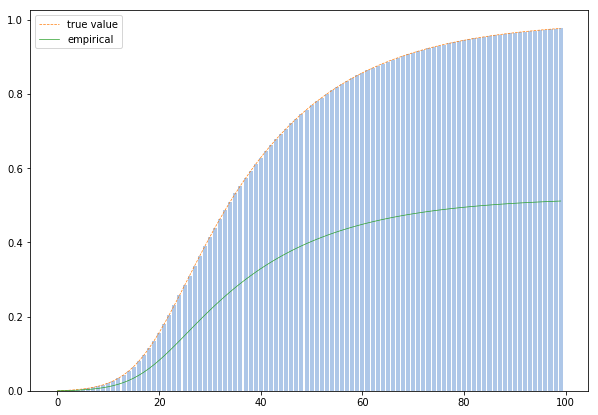

In [25]:
plt.figure(figsize=(10,7))
plt.bar(list(range(100)), drdt, color=tableau20[1])
plt.plot(list(range(100)), drdt, '--', color=tableau20[2], linewidth=0.7, label='true value')
plt.plot(list(range(100)), y, '-', color=tableau20[4], linewidth=0.7, label='empirical')
plt.legend()
plt.savefig("R_randb.png")

In [26]:
np.savetxt("y.csv", y, delimiter=",")